# Imports

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

# Functions

In [2]:
# Converts tensor into image
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)



# Load Images

## Load images of choice

In [3]:
# Optional
# Change to local path
style_path = "images/monnalisa.jpg"
# Change to local path
content_path = "images/album.jpg"


# Visualize the input

simple function to load an image and limit its maximum dimension to 512 pixels

In [4]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

function to display the image

In [5]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

        plt.imshow(image)
    if title:
        plt.title(title)

Load the images

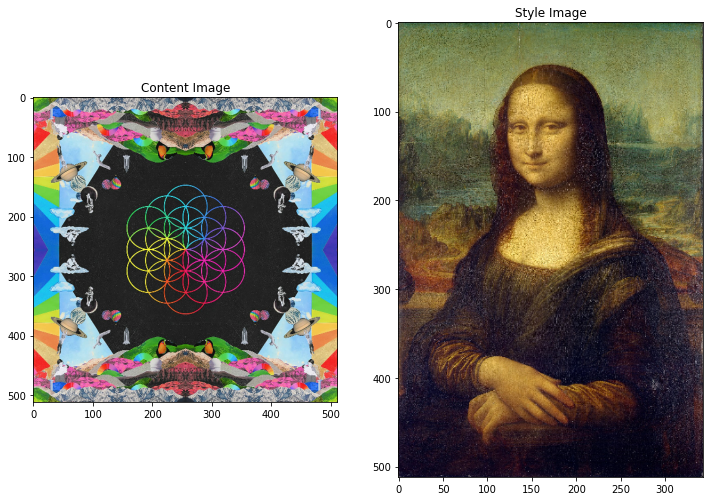

In [6]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

# Define content and style representations

Use the intermediate layers of the model to get the content and style representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like wheels or eyes. In this case, you are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.

In [7]:
# Load a VGG19 and test run it on our image to ensure it's used correctly:

x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574726144/574710816 [==============================] - 179s 0us/step


TensorShape([1, 1000])

In [8]:
# Check Predictions for current image
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

49152/35363 [=========================================] - 0s 1us/step


[('umbrella', 0.69258595),
 ('birdhouse', 0.0635508),
 ('pillow', 0.04447533),
 ('jigsaw_puzzle', 0.027767658),
 ('handkerchief', 0.025199259)]

Now load a VGG19 without the classification head, and list the layer names



In [9]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)

80150528/80134624 [==============================] - 29s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Choose intermediate layers from the network to represent the style and content of the image:



In [10]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

Intermediate layers for style and content
So why do these intermediate outputs within our pretrained image classification network allow us to define style and content representations?

At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image. This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

This is also a reason why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g. cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor. By accessing intermediate layers of the model, you're able to describe the content and style of input images.



# Build the model: FILL THE CODE

The networks in tf.keras.applications are designed so you can easily extract the intermediate layer values using the Keras functional API.

To define a model using the functional API, specify the inputs and outputs:

model = Model(inputs, outputs)

This following function builds a VGG19 model that returns a list of intermediate layer outputs:

In [11]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

    # We want to use it as an extractor, so set to false train option
    vgg.trainable = False

    # FILL THE CODE: outputs must be a list containing tensor with the outputs 
    # of each layer contained in layer_names
    # HINT: from a functional model the outputs can be extracted using 
    # model.get_layer(name).output
    outputs = [vgg.get_layer(name).output for name in layer_names]


    # FILL THE CODE Build a functional model that gets vgg.input as input and  
    # outputs the content of each layer contained in layer_names
    model = model = tf.keras.Model([vgg.input],outputs)
    return model

create model

In [12]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()
    
# Model summary
style_extractor.summary()

block1_conv1
  shape:  (1, 512, 343, 64)
  min:  0.0
  max:  679.2384
  mean:  19.822128

block2_conv1
  shape:  (1, 256, 171, 128)
  min:  0.0
  max:  2131.271
  mean:  100.18975

block3_conv1
  shape:  (1, 128, 85, 256)
  min:  0.0
  max:  4510.117
  mean:  90.885216

block4_conv1
  shape:  (1, 64, 42, 512)
  min:  0.0
  max:  9647.186
  mean:  407.53278

block5_conv1
  shape:  (1, 32, 21, 512)
  min:  0.0
  max:  2511.3057
  mean:  30.369059

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1

# Calculate style

The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. 

$G_{cd}^l  = \frac{\sum_{ij}F_{ijc}^l(x)F_{ijd}^l(x)}{IJ}$

where $l$ is the layer index, $i$ and $j$ are the pixel indices and $c$ $d$ represent two different filters, $x$ is a general input to the layer 

In [13]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) # Check
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

# Extract syle and content

In [14]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

In [15]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

    print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.36743432
    max:  17466.473
    mean:  1045.071

Contents:
   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  287274.78
    mean:  34436.406

Contents:
   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  1478884.8
    mean:  47391.25

Contents:
   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  15714926.0
    mean:  579495.5

Contents:
   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  225047.53
    mean:  3770.2515

Contents:
   block5_conv2
    shape:  (1, 32, 32, 512)
    min:  0.0
    max:  2457.8171
    mean:  24.565168


# Run gradient descent: FILL THE CODE

In [16]:
# Set your style and content target values:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# Define a tf.Variable to contain the image to optimize. To make this quick, initialize it with the content image 
image = tf.Variable(content_image)

# Clip the image
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# Optimizer 
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight=1e-2
content_weight=1e4

# To optimize this, use a weighted combination of the two losses to get the total loss:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

# FILL THE CODE: here you will do a custom training loop as explained in the slide
# is a little bit different from the classic training loop since you will be operating
# directly on the image, not on the model, what you need to do is:
# -compute output
# -compute loss
# - compute gradient
# - apply gradient
# - clip the image: image.assign(clip_0_1(image))
@tf.function()
def train_step(image): #costum training loop
   
   with tf.GradientTape() as tape:
     outputs = extractor(image)
     loss = style_content_loss(outputs)

   grad = tape.gradient(loss, image)
   opt.apply_gradients([(grad, image)])
   image.assign(clip_0_1(image))


In [ ]:

# FILL THE CODE: perform a few training steps
train_step(image)
train_step(image)

# Plot the image
tensor_to_image(image)

Perform a longer optimization

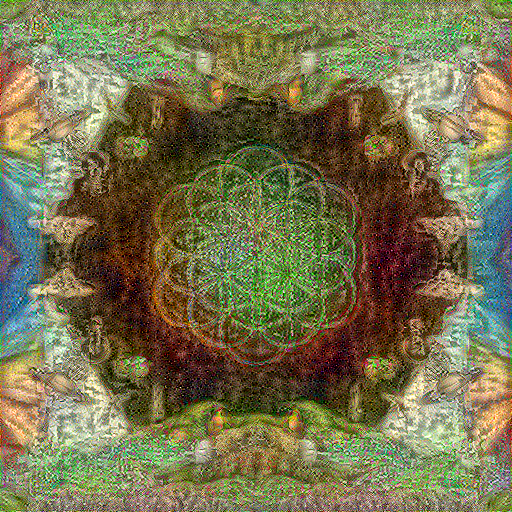

Train step: 100
Total time: 189.8


In [18]:
import time
start = time.time()

epochs = 100
steps_per_epoch = 1

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))
end = time.time()
print("Total time: {:.1f}".format(end-start))

# Total Variation Loss


*   This basic implementation produces a lot of high frequency artifacts
*   We can decrease this using an explicit regularization term on the high-frequency components -> *total variation loss*



In [ ]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

Plot to show high-frequency components

as you can see after style transfer, high-frequency components have increased

In [ ]:

x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

The regularization loss associated with this is the sum of squares of the high-pass values (already implemented in tensorflow!)

In [ ]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

# Custom
total_variation_loss_custom =total_variation_loss(image).numpy()
# Tensorflow
total_variation_loss =tf.image.total_variation(image).numpy()

print('Total variation loss (custom)',total_variation_loss_custom)
print('Total variation loss',total_variation_loss)

# Re-run the optimization

In [ ]:
# Choose a weight for the total_variation_loss
total_variation_weight=30

# FILL THE CODE: Include it in the train_step function
# Repeat the same custom training loop (tf.GradientTape...) that you did before
# only this take take into account the weighted total_variation loss and sum it
# to the loss

@tf.function()
def train_step(image):

  with tf.Gradienttape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.tf.assign(clip_0_1(image))

In [ ]:
# Re-initialize the optimization variable:
image = tf.Variable(content_image)

# Run the optimization
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

# Fast style transfer -> tensorflow hub

In [ ]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)